In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
import torch
from torch.utils.data import random_split


In [2]:

data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor()
        
    ])

In [3]:
dataset = ImageFolder("sound\images", transform=data_transform)


In [67]:
# Part 1 - Data Preprocessing
# Convolutional Neural Network

# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('sound/images',
                                                 target_size = (64, 64),
                                                 batch_size = 32)
test_set = test_datagen.flow_from_directory("../Test images",
                                            target_size = (64, 64),
                                            batch_size = 32)
                                            


Found 1972 images belonging to 3 classes.
Found 118 images belonging to 3 classes.


In [4]:
category_map = {2: 'tree_cutting',
 1: 'gun_shot',
 0: 'bg_noise'}

In [5]:
img, label = dataset[0]
print(img.shape, category_map[label])
img

torch.Size([3, 32, 32]) bg_noise


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [6]:
print(dataset.classes)

['bg_noise', 'gun_shot', 'tree_cutting']


In [7]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  bg_noise (0)


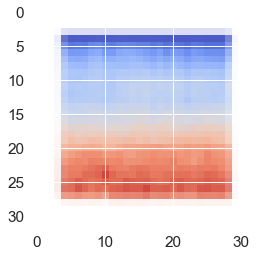

In [321]:
show_example(*dataset[130])

In [9]:
random_seed = 42
torch.manual_seed(random_seed);

In [10]:

val_size = int(len(dataset)*0.25)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)


(1479, 493)

In [11]:
val_size = val_size - 100
val_ds, test_ds = random_split(val_ds, [val_size, 100])
len(val_ds), len(test_ds)

(393, 100)

In [12]:
from torch.utils.data.dataloader import DataLoader
batch_size=32

In [13]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

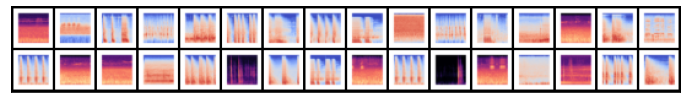

In [15]:
show_batch(train_dl)


In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class PytorchCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,3))
        
    def forward(self, xb):
        return self.network(xb)

In [19]:
model = PytorchCnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 32, 32])
out.shape: torch.Size([32, 3])
out[0]: tensor([0.0190, 0.0272, 0.0753], grad_fn=<SelectBackward>)


In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
model = to_device(PytorchCnnModel(), device)


In [41]:
evaluate(model, val_dl)


{'val_loss': 1.0993093252182007, 'val_acc': 0.3442460596561432}

In [42]:
num_epochs = 27
opt_func = torch.optim.Adam
lr = 0.001

%%time

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


In [43]:
%%time

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.9352, val_loss: 0.8557, val_acc: 0.5228
Epoch [1], train_loss: 0.7513, val_loss: 0.8195, val_acc: 0.6034
Epoch [2], train_loss: 0.7241, val_loss: 0.7436, val_acc: 0.6818
Epoch [3], train_loss: 0.6288, val_loss: 0.7102, val_acc: 0.7470
Epoch [4], train_loss: 0.6141, val_loss: 0.5567, val_acc: 0.7850
Epoch [5], train_loss: 0.5742, val_loss: 0.6558, val_acc: 0.7423
Epoch [6], train_loss: 0.5323, val_loss: 0.5039, val_acc: 0.8095
Epoch [7], train_loss: 0.5008, val_loss: 0.4990, val_acc: 0.8185
Epoch [8], train_loss: 0.4073, val_loss: 0.3815, val_acc: 0.8455
Epoch [9], train_loss: 0.3516, val_loss: 0.3507, val_acc: 0.8857
Epoch [10], train_loss: 0.2814, val_loss: 0.2917, val_acc: 0.8745
Epoch [11], train_loss: 0.2902, val_loss: 0.3386, val_acc: 0.8745
Epoch [12], train_loss: 0.2310, val_loss: 0.2616, val_acc: 0.9038
Epoch [13], train_loss: 0.2390, val_loss: 0.2896, val_acc: 0.8991
Epoch [14], train_loss: 0.2225, val_loss: 0.2895, val_acc: 0.9216
Epoch [15], train_lo

In [261]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs in Pytorch model');

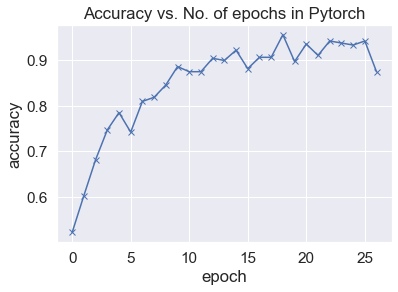

In [262]:
plot_accuracies(history)

In [263]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs for Pytorch model');

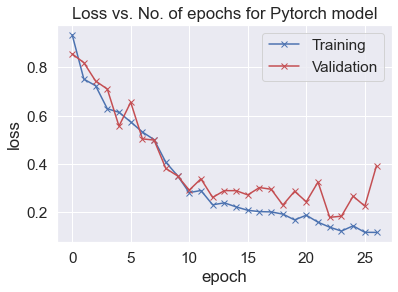

In [264]:
plot_losses(history)

In [48]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.29199710488319397, 'val_acc': 0.9097222089767456}

In [294]:
train_loader = DeviceDataLoader(DataLoader(train_ds, batch_size*2), device)
result = evaluate(model, train_loader)
result

{'val_loss': 0.1901586800813675, 'val_acc': 0.916573703289032}

In [49]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')


In [243]:
test_dataset = ImageFolder("../Test images", transform=data_transform)
test_loader = DeviceDataLoader(DataLoader(test_dataset, 1), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.23573672771453857, 'val_acc': 0.9047619104385376}

In [198]:
output = list()
for i, (inputs, targets) in enumerate(test_loader):
    yhat = model(inputs)
        # retrieve numpy array
    yhat = yhat.detach().numpy()
    yhat = yhat.argmax(axis=1)
    yhat = yhat.reshape((len(yhat), 1))
    output.append(yhat[0][0])
    print(yhat) 

[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[2]]
[[2]]
[[0]]
[[0]]
[[2]]
[[2]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[0]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[1]]
[[0]]
[[1]]
[[1]]
[[0]]
[[0]]
[[0]]
[[1]]
[[0]]
[[1]]
[[1]]
[[1]]
[[0]]
[[0]]
[[2]]
[[0]]
[[1]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[0]]
[[0]]
[[2]]
[[0]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]]
[[2]

In [244]:
%store output

Stored 'output' (list)


In [ ]:
predictions, actuals = list(), list()
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labes
        yhat = yhat.argmax(axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
        print(predictions)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)      
    return 1

In [287]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [274]:
from tensorflow.keras.regularizers import l2
# Part 2 - Building the CNN
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
## for mulitclassification
cnn.add(Dense(3, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='softmax'))
cnn.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

In [289]:
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 30)

Epoch 1/37
62/62 [==============================] - 7s 107ms/step - loss: 0.7646 - accuracy: 0.9290 - val_loss: 0.7123 - val_accuracy: 0.9661
Epoch 2/37
62/62 [==============================] - 7s 105ms/step - loss: 0.7653 - accuracy: 0.9290 - val_loss: 0.8328 - val_accuracy: 0.8729
Epoch 3/37
62/62 [==============================] - 7s 107ms/step - loss: 0.7667 - accuracy: 0.9290 - val_loss: 0.7185 - val_accuracy: 0.9661
Epoch 4/37
62/62 [==============================] - 7s 105ms/step - loss: 0.7551 - accuracy: 0.9371 - val_loss: 0.7060 - val_accuracy: 0.9746
Epoch 5/37
62/62 [==============================] - 7s 107ms/step - loss: 0.7544 - accuracy: 0.9397 - val_loss: 0.7124 - val_accuracy: 0.9746
Epoch 6/37
62/62 [==============================] - 7s 107ms/step - loss: 0.7488 - accuracy: 0.9447 - val_loss: 0.6878 - val_accuracy: 0.9915
Epoch 7/37
62/62 [==============================] - 7s 107ms/step - loss: 0.7648 - accuracy: 0.9275 - val_loss: 0.6872 - val_accuracy: 0.9915
Epoch 

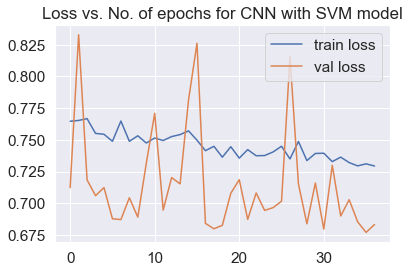

In [324]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('LossVal_loss')
plt.title('Loss vs. No. of epochs for CNN with SVM model');



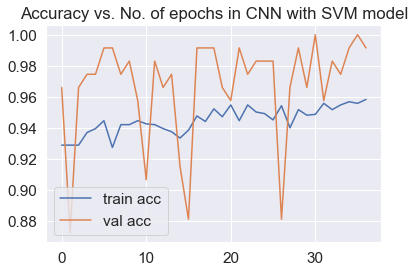

In [325]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('AccVal_acc')
plt.title('Accuracy vs. No. of epochs in CNN with SVM model');

In [280]:
output_svm_cnn=list()

In [281]:
output_svm_cnn

[]

In [282]:
import os
#C:\Users\mohia\Documents\Thesis\New dataset Creation\axe sound
path = '../../Thesis/Test images/bg_noise'
files = os.listdir(path)
c =0
import numpy as np
from tensorflow.keras.preprocessing import image
result
for f in files:
    c+=1
    file_name = os.path.join(os.path.abspath(path),str(f))
    test_image = image.load_img(file_name, target_size = (64,64))
    test_image = image.img_to_array(test_image)
    test_image=test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)
    output_svm_cnn.append(np.argmax(result,axis =1)[0])
print(c)   


61


array([2, 0, 1, ..., 1, 0, 0], dtype=int64)

In [283]:
import os
#C:\Users\mohia\Documents\Thesis\New dataset Creation\axe sound
path = '../../Thesis/Test images/gun_shot'
files = os.listdir(path)
c=0
import numpy as np
from tensorflow.keras.preprocessing import image
result
for f in files:
    c+=1
    file_name = os.path.join(os.path.abspath(path),str(f))
    test_image = image.load_img(file_name, target_size = (64,64))
    test_image = image.img_to_array(test_image)
    test_image=test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)
    output_svm_cnn.append(np.argmax(result,axis =1)[0])
    
print(c)

57


In [284]:
import os
#C:\Users\mohia\Documents\Thesis\New dataset Creation\axe sound
path = '../../Thesis/Test images/tree_cutting'
files = os.listdir(path)
c=0
import numpy as np
from tensorflow.keras.preprocessing import image
result
for f in files:
    c+=1
    file_name = os.path.join(os.path.abspath(path),str(f))
    test_image = image.load_img(file_name, target_size = (64,64))
    test_image = image.img_to_array(test_image)
    test_image=test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)
    output_svm_cnn.append(np.argmax(result,axis =1)[0])
    
print(c)

50


In [242]:
%store output_svm_cnn

Stored 'output_svm_cnn' (list)


In [245]:
%store -r final_y_test

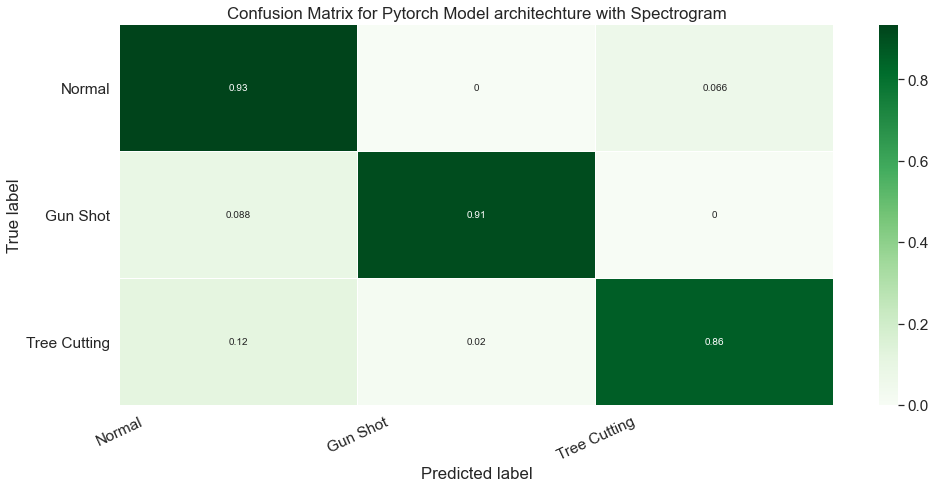

In [270]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(final_y_test, np.array(output))
#print(accuracy_score(final_y_test, output))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Normal','Gun Shot','Tree Cutting']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Pytorch Model architechture with Spectrogram')
plt.show()

In [295]:
#Model accuracy on test data
from sklearn.metrics import classification_report
target_names = ['Normal', 'Gunshot', 'Tree Cutting']
print(classification_report(final_y_test, np.array(output), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.84      0.93      0.88        61
     Gunshot       0.98      0.91      0.95        57
Tree Cutting       0.91      0.86      0.89        50

    accuracy                           0.90       168
   macro avg       0.91      0.90      0.91       168
weighted avg       0.91      0.90      0.91       168



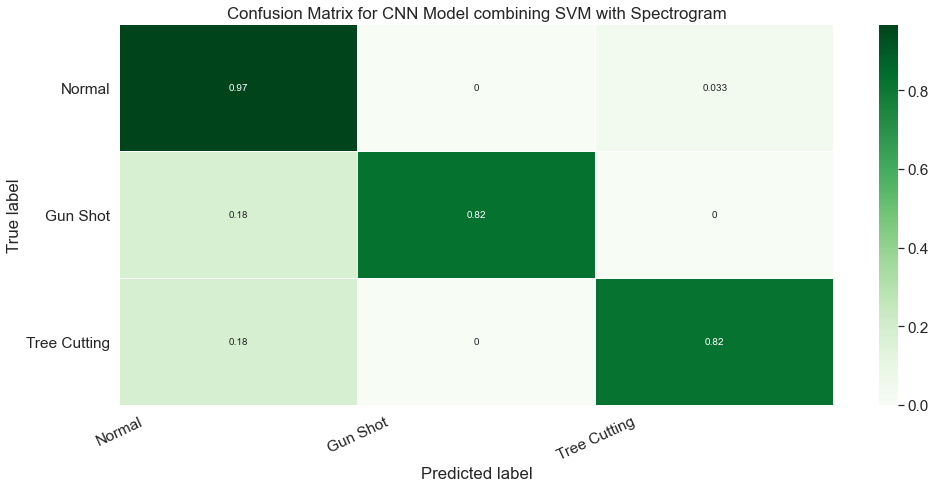

In [313]:
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(final_y_test, output_svm_cnn)
#print(accuracy_score(final_y_test, model_y_pred_test.argmax(axis=1)))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Normal','Gun Shot','Tree Cutting']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for CNN Model combining SVM with Spectrogram')
plt.show()

In [318]:
#Model accuracy on test data
from sklearn.metrics import classification_report
target_names = ['Normal', 'Gunshot', 'Tree Cutting']
print(classification_report(final_y_test, output_svm_cnn, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.76      0.97      0.85        61
     Gunshot       1.00      0.82      0.90        57
Tree Cutting       0.95      0.82      0.88        50

    accuracy                           0.88       168
   macro avg       0.90      0.87      0.88       168
weighted avg       0.90      0.88      0.88       168

